In [1]:
import pandas as pd
import numpy as np
import sqlite3
import shutil
import ipynbname
import datetime
import sys
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MultiLabelBinarizer
from sklearn.impute import SimpleImputer

from pytorch_tabular import TabularModel
from pytorch_tabular.models import NodeConfig
from pytorch_tabular.config import (
    DataConfig,
    OptimizerConfig,
    TrainerConfig,
    ExperimentConfig,
)


from Process_Function import RareCategoryTransformer
from Visualization_function import *
from LG_Aimers_6th.cal_auc import calculate_auc
import warnings
warnings.filterwarnings(action='ignore')

## 2. Data Load

In [2]:
train_path = '../data/custom_train_1.csv'
test_path = '../data/custom_test_1.csv'
sample_path = '../data/sample_submission.csv'

# train_path = '../data/train.csv'
# test_path = '../data/test.csv'
# sample_path = '../data/sample_submission.csv'

# 학습/평가 데이터 로드
train = pd.read_csv(train_path).drop(columns=['ID'])
test = pd.read_csv(test_path).drop(columns=['ID'])

print(train.shape, test.shape)

train['임신 성공 여부'].value_counts(normalize=True)

(205080, 68) (51271, 67)


임신 성공 여부
0    0.741652
1    0.258348
Name: proportion, dtype: float64

In [3]:
train

,시술 시기 코드,시술 당시 나이,임신 시도 또는 마지막 임신 경과 연수,시술 유형,특정 시술 유형,배란 자극 여부,배란 유도 유형,단일 배아 이식 여부,착상 전 유전 검사 사용 여부,착상 전 유전 진단 사용 여부,...,기증 배아 사용 여부,대리모 여부,PGD 시술 여부,PGS 시술 여부,난자 채취 경과일,난자 해동 경과일,난자 혼합 경과일,배아 이식 경과일,배아 해동 경과일,임신 성공 여부
0,TRDQAZ,만43-44세,NaN,IVF,IVF,0,알 수 없음,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0
1,TRJXFG,만35-37세,NaN,IVF,Unknown,0,알 수 없음,1.0,NaN,0.0,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1
2,TRXQMD,만18-34세,NaN,DI,IUI,0,알 수 없음,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,TRDQAZ,만35-37세,NaN,IVF,IVF,1,기록되지 않은 시행,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,5.0,NaN,0
4,TRVNRY,만18-34세,NaN,IVF,IVF,1,기록되지 않은 시행,1.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,3.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205075,TRXQMD,만18-34세,NaN,IVF,Unknown,0,알 수 없음,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0
205076,TRYBLT,만18-34세,NaN,IVF,IVF,1,기록되지 않은 시행,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,3.0,NaN,0
205077,TRCMWS,만18-34세,NaN,IVF,Unknown,0,알 수 없음,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0
205078,TRYBLT,만18-34세,NaN,IVF,IVF,1,기록되지 않은 시행,1.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,5.0,NaN,1


In [6]:
def drop_columns(df):
    cols = [
        '불임 원인 - 여성 요인',  # 고유값 1
        '불임 원인 - 정자 면역학적 요인',  # train, test 모두 '1'인 데이터 1개 >> 신뢰할 수 없음
        '난자 해동 경과일',
    ]
    df = df.drop(cols, axis=1)
    return df

def 특정시술유형(train, test):
    def categorize_procedure(proc):
        tokens = [token.strip() for token in proc.split(",") if token.strip() and not token.strip().isdigit()]
        # 우선순위에 따른 범주화
        if tokens.count("Unknown") >= 1:
            return "Unknown"
        if tokens.count("AH") >= 1:
            return "AH"
        if tokens.count("BLASTOCYST") >= 1:
            return "BLASTOCYST"
        if tokens.count("ICSI") >= 2 or tokens.count("IVF") >= 2:
            return "2ICSI_2IVF"
        if tokens.count("IVF") >= 1 and tokens.count("ICSI") >= 1:
            return "IVF_ICSI"
        if tokens == "ICSI":
            return "ICSI"
        if tokens == "IVF":
            return "IVF"
        return ",".join(tokens) if tokens else None

    for df in [train, test]:
        df['특정 시술 유형'] = df['특정 시술 유형'].str.replace(" / ", ",")
        df['특정 시술 유형'] = df['특정 시술 유형'].str.replace(":", ",")
        df['특정 시술 유형'] = df['특정 시술 유형'].str.replace(" ", "")

    counts = train['특정 시술 유형'].value_counts()
    allowed_categories = counts[counts >= 100].index.tolist()

    # allowed_categories에 속하지 않는 값은 "Unknown"으로 대체
    train.loc[~train['특정 시술 유형'].isin(allowed_categories), '특정 시술 유형'] = "Unknown"
    test.loc[~test['특정 시술 유형'].isin(allowed_categories), '특정 시술 유형'] = "Unknown"

    train['특정 시술 유형'] = train['특정 시술 유형'].apply(categorize_procedure)
    test['특정 시술 유형'] = test['특정 시술 유형'].apply(categorize_procedure)

    train['시술유형_통합'] = train['시술 유형'].astype(str) + '_' + train['특정 시술 유형'].astype(str)
    test['시술유형_통합'] = test['시술 유형'].astype(str) + '_' + test['특정 시술 유형'].astype(str)

    drop_cols = ['시술 유형', '특정 시술 유형']
    train = train.drop(drop_cols, axis=1)
    test = test.drop(drop_cols, axis=1)

    return train, test

def 시술횟수(df_train):
    for col in [col for col in df_train.columns if '횟수' in col]:
        df_train[col] = df_train[col].replace({'6회 이상':'6회'})
        df_train[col] = df_train[col].str[0].astype(int)
    df_train['시술_임신'] = df_train['총 임신 횟수'] - df_train['총 시술 횟수']
    df_train = df_train.drop('총 시술 횟수', axis=1)
    return df_train

def 배란유도유형(df_train, df_test):
    mapping = {
        '기록되지 않은 시행': 1,
        '알 수 없음': 0,
        '세트로타이드 (억제제)': 0,
        '생식선 자극 호르몬': 0,
    }
    df_train['배란 유도 유형'] = df_train['배란 유도 유형'].replace(mapping)
    df_test['배란 유도 유형'] = df_test['배란 유도 유형'].replace(mapping)
    return df_train, df_test

def 난자기증자나이(df_train, df_test):
    mapping = {
        '만20세 이하': 20,
        '만21-25세': 25,
        '만26-30세': 30,
        '만31-35세': 35,
        '알 수 없음': 20,  # 만20세 이하와 동일하게 처리
    }
    df_train['난자 기증자 나이'] = df_train['난자 기증자 나이'].replace(mapping)
    df_test['난자 기증자 나이'] = df_test['난자 기증자 나이'].replace(mapping)
    return df_train, df_test

def 배아생성주요이유(df_train, df_test):
    df_train['배아 생성 주요 이유'] = df_train['배아 생성 주요 이유'].fillna('DI')
    df_test['배아 생성 주요 이유'] = df_test['배아 생성 주요 이유'].fillna('DI')

    df_train['배아 생성 이유 리스트'] = df_train['배아 생성 주요 이유'].apply(lambda x: [reason.strip() for reason in x.split(',')])
    df_test['배아 생성 이유 리스트'] = df_test['배아 생성 주요 이유'].apply(lambda x: [reason.strip() for reason in x.split(',')])

    mlb = MultiLabelBinarizer()
    train_one_hot = pd.DataFrame(
        mlb.fit_transform(df_train['배아 생성 이유 리스트']),
        columns=mlb.classes_,
        index=df_train.index
    )
    train_one_hot.columns = ['배아생성이유_' + col for col in train_one_hot.columns]

    test_one_hot = pd.DataFrame(
        mlb.transform(df_test['배아 생성 이유 리스트']),
        columns=mlb.classes_,
        index=df_test.index
    )
    test_one_hot.columns = ['배아생성이유_' + col for col in test_one_hot.columns]

    df_train = pd.concat([df_train, train_one_hot], axis=1)
    df_test = pd.concat([df_test, test_one_hot], axis=1)

    cols_to_drop = [
        '배아 생성 주요 이유',
        '배아 생성 이유 리스트',
        '배아생성이유_연구용',
        '배아생성이유_DI'
    ]
    df_train = df_train.drop(cols_to_drop, axis=1, errors='ignore')
    df_test = df_test.drop(cols_to_drop, axis=1, errors='ignore')

    cols = ['배아생성이유_기증용',
            '배아생성이유_난자 저장용',
            '배아생성이유_배아 저장용',
            '배아생성이유_현재 시술용']

    df_train[cols] = df_train[cols].div(df_train[cols].sum(axis=1).replace(0, np.nan), axis=0).fillna(0)
    df_test[cols] = df_test[cols].div(df_test[cols].sum(axis=1).replace(0, np.nan), axis=0).fillna(0)

    return df_train, df_test

def 단일배아이식여부(df_train, df_val):
    df_train['단일 배아 이식 여부'] = df_train['단일 배아 이식 여부'].fillna(0)
    df_val['단일 배아 이식 여부'] = df_val['단일 배아 이식 여부'].fillna(0)
    return df_train, df_val


def 기증자정자와혼합된난자수(df_train, df_test):
    df_train["기증자 정자와 혼합된 난자 수"] = df_train["기증자 정자와 혼합된 난자 수"].fillna(2)
    df_test["기증자 정자와 혼합된 난자 수"] = df_test["기증자 정자와 혼합된 난자 수"].fillna(2)
    return df_train, df_test

def type_to_category(train, test, cols):
    train[cols] = train[cols].astype('category')
    test[cols] = test[cols].astype('category')
    return train, test

def impute_nan(train, test):
    cols_to_impute = [
        '임신 시도 또는 마지막 임신 경과 연수', # DI, IVF랑 관련 X
    ]
    imputer = SimpleImputer(strategy='mean')
    train[cols_to_impute] = imputer.fit_transform(train[cols_to_impute])
    test[cols_to_impute] = imputer.transform(test[cols_to_impute])

    cols_to_impute = [
        '난자 채취 경과일',
        '난자 혼합 경과일',
        '배아 이식 경과일',
        '배아 해동 경과일',

        '착상 전 유전 검사 사용 여부',
        'PGD 시술 여부',
        'PGS 시술 여부',

        ### DI only
        '착상 전 유전 진단 사용 여부',
        '총 생성 배아 수',
        '미세주입된 난자 수',
        '미세주입에서 생성된 배아 수',
        '이식된 배아 수',
        '미세주입 배아 이식 수',
        '저장된 배아 수',
        '미세주입 후 저장된 배아 수',
        '해동된 배아 수',
        '해동 난자 수',
        '수집된 신선 난자 수',
        '저장된 신선 난자 수',
        '혼합된 난자 수',
        '파트너 정자와 혼합된 난자 수',
        '기증자 정자와 혼합된 난자 수',
        '동결 배아 사용 여부',
        '신선 배아 사용 여부',
        '기증 배아 사용 여부',
        '대리모 여부',
        ### DI
    ]
    train[cols_to_impute] = train[cols_to_impute].fillna(0)
    test[cols_to_impute] = test[cols_to_impute].fillna(0)

    return train, test

def num_feature_scailing(train, test):
    # cols_to_divide = [
    #     '연간 소득',
    #     '최대 신용한도',
    #     '현재 대출 잔액',
    #     '현재 미상환 신용액',
    #     '월 상환 부채액',
    # ]
    # train[cols_to_divide] = train[cols_to_divide] / 100000
    # test[cols_to_divide] = test[cols_to_divide] / 100000

    cols_to_log = [
        '총 생성 배아 수',
    ]
    log_transformer = FunctionTransformer(np.log1p, validate=True)
    train[cols_to_log] = log_transformer.fit_transform(train[cols_to_log])
    test[cols_to_log] = log_transformer.transform(test[cols_to_log])

    # numeric_cols = train.select_dtypes(include=["number"]).columns.tolist()
    # cat_cols = [col for col in train.columns if pd.api.types.is_categorical_dtype(train[col])]
    # cols_to_scale = [
    #     col for col in numeric_cols
    #     if col not in cat_cols and col != '임신 성공 여부'
    # ]
    # scaler = StandardScaler()
    # train[cols_to_scale] = scaler.fit_transform(train[cols_to_scale])
    # test[cols_to_scale] = scaler.transform(test[cols_to_scale])

    return train, test

def all_process(train, val):
    # 기본 전처리 단계
    train, val = drop_columns(train), drop_columns(val)
    train, val = 특정시술유형(train, val)
    train, val = 시술횟수(train), 시술횟수(val)

    cols_to_encoding = [
        "시술 시기 코드",
        "시술 당시 나이",
        "배란 유도 유형",
        # "클리닉 내 총 시술 횟수",
        # "IVF 시술 횟수",
        # "DI 시술 횟수",
        # "총 임신 횟수",
        # "IVF 임신 횟수",
        # "DI 임신 횟수",
        # "총 출산 횟수",
        # "IVF 출산 횟수",
        # "DI 출산 횟수",
        "난자 출처",
        "정자 출처",
        "난자 기증자 나이",
        "정자 기증자 나이",
        '시술유형_통합',
    ]
    train, val = type_to_category(train, val, cols=cols_to_encoding)

    train, val = 단일배아이식여부(train, val)
    train, val = 배란유도유형(train, val)
    train, val = 배아생성주요이유(train, val)

    train, val = impute_nan(train, val)
    train, val = num_feature_scailing(train, val)

    return train, val

train = pd.read_csv(train_path).drop(columns=['ID'])
test = pd.read_csv(test_path).drop(columns=['ID'])

train, test = all_process(train, test)

print(train.shape, test.shape)

(205080, 67) (51271, 66)


In [7]:
train

,시술 시기 코드,시술 당시 나이,임신 시도 또는 마지막 임신 경과 연수,배란 자극 여부,배란 유도 유형,단일 배아 이식 여부,착상 전 유전 검사 사용 여부,착상 전 유전 진단 사용 여부,남성 주 불임 원인,남성 부 불임 원인,...,난자 혼합 경과일,배아 이식 경과일,배아 해동 경과일,임신 성공 여부,시술유형_통합,시술_임신,배아생성이유_기증용,배아생성이유_난자 저장용,배아생성이유_배아 저장용,배아생성이유_현재 시술용
0,TRDQAZ,만43-44세,9.268338,0,0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0,IVF_IVF,-3,0.0,0.0,0.0,1.0
1,TRJXFG,만35-37세,9.268338,0,0,1.0,0.0,0.0,0,0,...,0.0,0.0,0.0,1,IVF_Unknown,-1,0.0,0.0,0.0,1.0
2,TRXQMD,만18-34세,9.268338,0,0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0,DI_IUI,-3,0.0,0.0,0.0,0.0
3,TRDQAZ,만35-37세,9.268338,1,1,0.0,0.0,0.0,0,0,...,0.0,5.0,0.0,0,IVF_IVF,-1,0.0,0.0,0.0,1.0
4,TRVNRY,만18-34세,9.268338,1,1,1.0,0.0,0.0,0,0,...,0.0,3.0,0.0,0,IVF_IVF,0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205075,TRXQMD,만18-34세,9.268338,0,0,0.0,0.0,0.0,0,0,...,0.0,1.0,0.0,0,IVF_Unknown,-1,0.0,0.0,0.0,1.0
205076,TRYBLT,만18-34세,9.268338,1,1,0.0,0.0,0.0,0,0,...,0.0,3.0,0.0,0,IVF_IVF,0,0.0,0.0,0.0,1.0
205077,TRCMWS,만18-34세,9.268338,0,0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0,IVF_Unknown,-2,0.0,0.0,0.0,1.0
205078,TRYBLT,만18-34세,9.268338,1,1,1.0,0.0,0.0,0,0,...,0.0,5.0,0.0,1,IVF_IVF,0,0.0,0.0,0.0,1.0


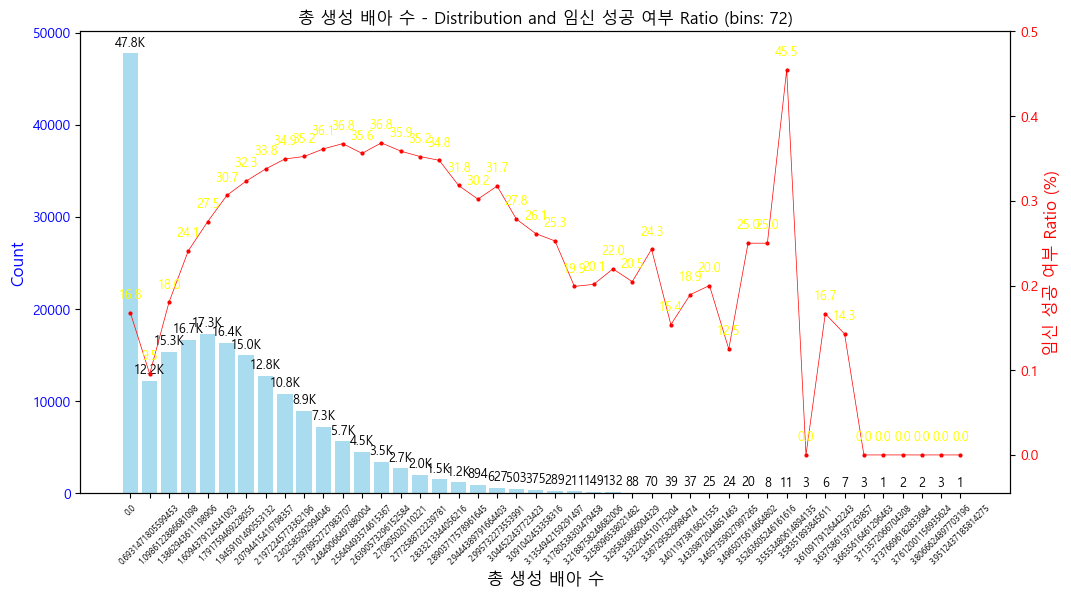

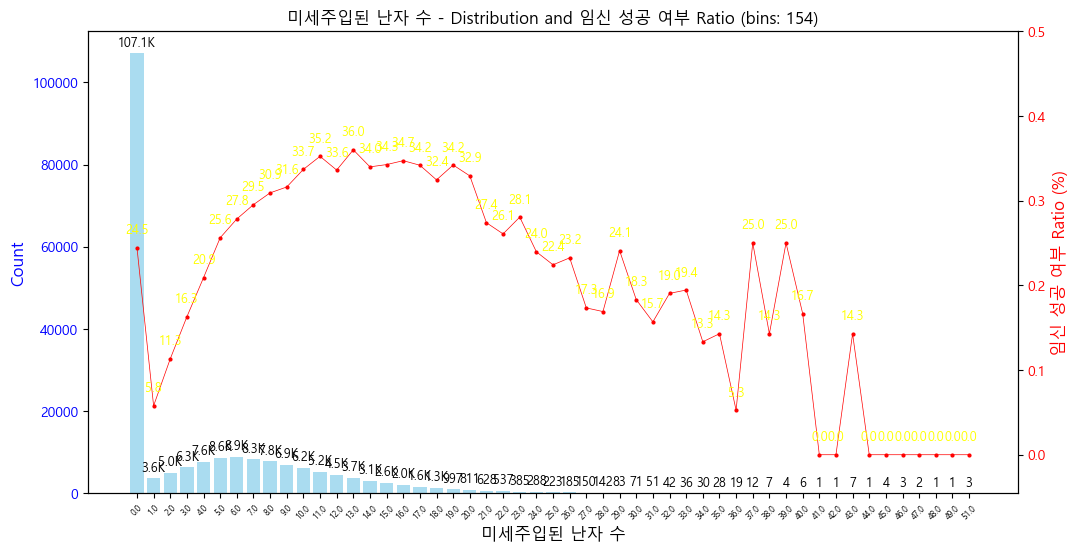

In [8]:
cols = [
    '총 생성 배아 수',
    '미세주입된 난자 수'
]

visualize_continuous_with_target(train, cols, target_column='임신 성공 여부')

In [8]:
# 실험 내용
experiment_desc = '''
NODE
'''

In [9]:
cat_cols = [col for col in train.columns if pd.api.types.is_categorical_dtype(train[col])]
numeric_cols = train.select_dtypes(include=["number"]).columns.tolist()
numeric_cols = [
    col for col in numeric_cols
    if col not in cat_cols and col != '임신 성공 여부'
]
print(f'범주형 변수: \n {cat_cols}')
print(f'수치형 변수: \n {numeric_cols}')


data_config = DataConfig(
    target=[
        "임신 성공 여부"
    ],
    continuous_cols=numeric_cols,
    categorical_cols=cat_cols,
)

trainer_config = TrainerConfig(
    # auto_lr_find=True,  # Runs the LRFinder to automatically derive a learning rate
    batch_size=512,
    accumulate_grad_batches=1024,
    data_aware_init_batch_size=2000,
    auto_lr_find=True,
    max_epochs=100,
    accelerator='gpu',
    early_stopping='valid_loss',
    early_stopping_min_delta=0.001,
    early_stopping_mode='min',
    early_stopping_patience=3,
    checkpoints='valid_loss',
    checkpoints_path='saved_models',
    checkpoints_save_top_k=1,
    progress_bar='simple',
)
optimizer_config = OptimizerConfig()

범주형 변수: 
 ['시술 시기 코드', '시술 당시 나이', '배란 유도 유형', '난자 출처', '정자 출처', '난자 기증자 나이', '정자 기증자 나이', '시술유형_통합']
수치형 변수: 
 ['임신 시도 또는 마지막 임신 경과 연수', '배란 자극 여부', '단일 배아 이식 여부', '착상 전 유전 검사 사용 여부', '착상 전 유전 진단 사용 여부', '남성 주 불임 원인', '남성 부 불임 원인', '여성 주 불임 원인', '여성 부 불임 원인', '부부 주 불임 원인', '부부 부 불임 원인', '불명확 불임 원인', '불임 원인 - 난관 질환', '불임 원인 - 남성 요인', '불임 원인 - 배란 장애', '불임 원인 - 자궁경부 문제', '불임 원인 - 자궁내막증', '불임 원인 - 정자 농도', '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수', 'DI 시술 횟수', '총 임신 횟수', 'IVF 임신 횟수', 'DI 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수', 'DI 출산 횟수', '총 생성 배아 수', '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수', '미세주입 배아 이식 수', '저장된 배아 수', '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수', '혼합된 난자 수', '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수', '동결 배아 사용 여부', '신선 배아 사용 여부', '기증 배아 사용 여부', '대리모 여부', 'PGD 시술 여부', 'PGS 시술 여부', '난자 채취 경과일', '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일', '시술_임신', '배아생성이유_기증용', '배아생성이유_난자 저장용', '배아생성이유_배아 저장용', '배아생성이유_현재 시술용']


In [11]:
n_splits = 5
# seed_list = [42, 333, 777, 2024, 77]
seed_list = [777]
all_auc = []
test_preds = []
is_first = True

for seed in seed_list:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    auc_scores = []
    fold_test_preds = []

    train = pd.read_csv(train_path).drop(columns=['ID'])
    test = pd.read_csv(test_path).drop(columns=['ID'])

    for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train['임신 성공 여부'])):
        fold_train, fold_valid = train.iloc[train_idx].copy().reset_index(drop=True), train.iloc[valid_idx].copy().reset_index(drop=True)
        fold_train2 = fold_train.copy()
        fold_test = test.copy()

        fold_train, fold_valid = all_process(fold_train, fold_valid)
        fold_train2, fold_test = all_process(fold_train2, fold_test)

        model_config = NodeConfig(
            task="classification",
            learning_rate=0.001,
            embedding_dims=None,
            embedding_dropout=0.0,
            num_layers=1,
            num_trees=2048,
            additional_tree_output_dim=3,
            depth=6,
            choice_function='entmax15',
            bin_function='entmoid15',
            max_features=None,
            input_dropout=0.0,
            seed=seed,
        )

        tabular_model = TabularModel(
            data_config=data_config,
            model_config=model_config,
            optimizer_config=optimizer_config,
            trainer_config=trainer_config,
            verbose=True,
        )

        tabular_model.fit(train=fold_train, validation=fold_valid, seed=seed)

        valid_preds = tabular_model.predict(fold_valid).iloc[:, 1]
        fold_auc = roc_auc_score(fold_valid['임신 성공 여부'], valid_preds)

        auc_scores.append(fold_auc)
        test_pred = tabular_model.predict(fold_test).iloc[:, 1]
        fold_test_preds.append(test_pred)

    test_preds.append(np.mean(fold_test_preds, axis=0))

    # 각 seed별 평균 AUC와 표준편차 출력
    seed_auc_mean = np.mean(auc_scores)
    seed_auc_std = np.std(auc_scores)
    all_auc.append(seed_auc_mean)
    print(f"Seed {seed} - Average AUC: {seed_auc_mean:.5f} (STD: {seed_auc_std:.5f})")
    print('=' * 60)



# 전체 결과에 대한 평균 및 표준편차 출력
total_auc_mean = np.mean(all_auc)
total_auc_std = np.std(all_auc)
print('-' * 60)
print(f'Total Average AUC: {total_auc_mean:.6f} (STD: {total_auc_std:.6f})')

2025-03-15 05:56:16,396 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 777


2025-03-15 05:56:16,417 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-03-15 05:56:16,574 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-03-15 05:56:17,204 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: NODEModel

2025-03-15 05:56:17,367 - {pytorch_tabular.models.node.node_model:74} - INFO - Data Aware Initialization of NODE   
using a forward pass with 2000 batch size....

2025-03-15 05:56:22,679 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-03-15 05:56:22,727 - {pytorch_tabular.tabular_model:656} - INFO - Auto LR Find Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [23]:
old_auc = 0.744533 * 100
old_std = 0.001171 * 100

new_auc = total_auc_mean * 100
new_std = total_auc_std * 100

def calculate_change(old_value, new_value):
    change = new_value - old_value
    percentage_change = (change / old_value) * 100 if old_value != 0 else float('inf')
    return change, percentage_change

def format_change(change):
    return f"{change:+.6f}"

# 각 지표의 변화량 계산
auc_change, auc_pct = calculate_change(old_auc, new_auc)
std_change, std_pct = calculate_change(old_std, new_std)

# 결과 출력
print("\n========== 모델 성능 변화 ==========")
print(f"{'Metric':<8}  {'AUC':>12}  {'Acc':>12}")
print("-" * 36)
print(f"{'Old':<8}  {old_auc:>12.6f}  {old_std:>12.6f}")
print(f"{'New':<8}  {new_auc:>12.6f}  {new_std:>12.6f}")
print(f"{'Change':<8}  {format_change(auc_change):>12}  {format_change(std_change):>12}")
print(f"{'% Change':<8}  {auc_pct:>11.4f}%  {std_pct:>11.4f}%")
print("=" * 36)


========== 모델 성능 변화 ==========
Metric             AUC           Acc
------------------------------------
Old          74.453300      0.117100
New          73.985216      0.000000
Change       -0.468084     -0.117100
% Change      -0.6287%    -100.0000%


In [24]:
sample_submission = pd.read_csv(sample_path)
sample_submission['채무 불이행 확률'] = np.mean(test_preds, axis=0)

ratio = train['채무 불이행 여부'].value_counts(normalize=True)[1]
real_true_count = int(ratio * len(sample_submission))
print(f'test의 True 갯수: {real_true_count:<5} (추정)')

count = (sample_submission['채무 불이행 확률'] >= 0.5).sum()
print(f'test의 True 갯수: {count:<5} (예측 결과)')

test의 True 갯수: 703   (추정)
test의 True 갯수: 238   (예측 결과)


In [25]:
now = datetime.datetime.now().strftime("%m%d_%H%M")

In [26]:
submission_path = 'Submission'
if not os.path.exists(submission_path):
    os.makedirs(submission_path)

code_dir = 'Code'
if not os.path.exists(code_dir):
    os.makedirs(code_dir)

submission_name = f"submission_{now}.csv"
new_notebook_name = f"code_{now}.ipynb"

sample_submission.to_csv(os.path.join(submission_path, submission_name), encoding='UTF-8-sig', index=False)

current_notebook = ipynbname.path()
new_notebook_path = os.path.join(code_dir, new_notebook_name)
shutil.copy(current_notebook, new_notebook_path)

print(f"Notebook saved in '{code_dir}' as '{new_notebook_name}'")

Notebook saved in 'Code' as 'code_0311_2305.ipynb'


In [27]:
# 📌 SQLite 데이터베이스 설정
db_path = "lgbm_experiment_results.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# 📌 테이블 생성 (처음 실행 시)
cursor.execute('''
CREATE TABLE IF NOT EXISTS experiments (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    code_name TEXT,
    experiment_desc TEXT,
    auc REAL,
    std REAL
)
''')

In [28]:
# 데이터 삽입
cursor.execute('''
INSERT INTO experiments (code_name, experiment_desc, auc, std)
VALUES (?, ?, ?, ?)
''', (new_notebook_name, experiment_desc.strip(), new_auc, new_std))

# 변경사항 저장 & 연결 종료
conn.commit()
conn.close()

print(f"Experiment '{new_notebook_name}' successfully saved in database")

Experiment 'code_0311_2305.ipynb' successfully saved in database


In [29]:
import sqlite3
import pandas as pd

# SQLite 데이터 조회 함수
def get_experiment_results(db_path="lgbm_experiment_results.db", num_results=10):
    """
    SQLite 데이터베이스에서 중복된 실험 데이터를 제거하고, 최근 num_results개의 실험 데이터를 불러오는 함수.
    Returns:
        - Pandas DataFrame: 중복 제거된 실험 데이터
    """
    conn = sqlite3.connect(db_path)

    # 중복 제거 & 최신 데이터 선택하는 SQL 쿼리
    query = f"""
    SELECT * FROM experiments
    WHERE id IN (
        SELECT MAX(id)  -- 가장 최신 데이터 선택
        FROM experiments
        GROUP BY code_name -- id 제외하고 중복 판단
    )
    ORDER BY id DESC  -- 최신 데이터부터 정렬
    LIMIT {num_results};
    """

    df = pd.read_sql_query(query, conn)
    conn.close()

    return df


df_results = get_experiment_results(num_results=100)
df_results.to_csv('lgbm_experiment_results.csv', index=False, encoding='utf-8-sig', float_format='%.4f')
df_results

,id,code_name,experiment_desc,auc,std
0,31,code_0311_2305.ipynb,NODE,73.985216,0.000000
1,30,code_0311_2246.ipynb,NODE,73.985216,0.000000
2,29,code_0311_2219.ipynb,NODE,73.816734,0.000000
3,28,code_0311_2039.ipynb,NODE,68.368928,0.000000
4,27,code_0310_2158.ipynb,TabPFN,74.776633,0.000000
5,26,code_0310_0048.ipynb,TabPFN,74.792289,0.000000
6,25,code_0309_2215.ipynb,TabPFN,74.813522,0.000000
7,24,code_0309_2212.ipynb,TabPFN,74.873422,0.033450
8,23,code_0306_2055.ipynb,"샘플링, 시드777, 캣부스트, 샘플 200개, 컬럼 랜덤 선택",74.588855,0.000000
9,22,code_0306_1946.ipynb,"샘플링, 시드777, 캣부스트, 샘플 200개, 컬럼 8개 고정",71.412381,0.000000
